In [1]:
import ddks
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from scipy.stats import beta
import time
plt.show()
plt.style.use('ah')

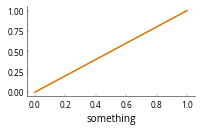

In [2]:
plt.plot([0, 1], [0, 1], label='y=x')
plt.xlabel('something')
plt.savefig('something.pdf')
plt.show()

In [3]:
m_1 = 3
m_2 = 2
r_1 = np.arange(0.0, m_1 + 0.5) / m_1
r_2 = np.arange(0.0, m_2 + 0.5) / m_2
X, Y = np.meshgrid(r_1, r_2)
x = np.abs(X - Y)
idx = np.argwhere(x == 0.5)
print(idx, idx[:, 0], idx[:, 1])
n_1s = m_1 * r_1[idx[:, 1]]
n_2s = m_2 * r_2[idx[:, 0]]
print(n_1s, n_2s)

[[1 0]
 [1 3]] [1 1] [0 3]
[0. 3.] [1. 1.]


In [4]:
n = np.ones((1000,))
k = np.ones((1000,))
start = time.time()
binom(n, k)
end = time.time()
print(f'{end - start:.2e}')
start = time.time()
for _ in range(1000):
    binom(1, 1)
end = time.time()
print(f'{end - start:.2e}')

# Ten times faster than loop logic!

1.02e-04
1.73e-03


In [5]:
_ddks = ddks.methods.ddKS()

In [6]:
# the probability of getting a binomial difference of 0.1 between a sample size two and three should be zero
assert _ddks.p_delta(0.1, 2, 3, 0.5) == 0.0

In [7]:
# the probability of getting a binomial difference of zero should be one if the binomial probability is
# 1.0, should always get 
print(_ddks.get_n1_n2(0.0, 3, 2))
print(_ddks.p_delta(0.0, 3, 2, 1.0))

(array([0., 3.]), array([0., 2.]))
1.0


In [8]:
# the probability of getting something more extreme than -0.1 should be 1.0
assert _ddks.p_gtdelta(-0.1, 100, 100, 0.5) == 1.0

In [9]:
# the probability of getting something more extreme than 1.0 should be 0.0
print(_ddks.p_gtdelta(1.0, 5, 5, 0.5))

0.0


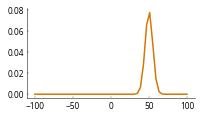

In [10]:
p = 0.5
m = 100.0
ns = np.linspace(-100, 100)
pbs = []
for n in ns:
    pbs.append(_ddks.p_bi(n, m, p))

plt.plot(ns, pbs)
plt.show()

# Null Hypothesis

In [11]:
import tqdm
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
ns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 70, 100]
ls = []
us = []
lps = []
ups = []
ps = []
u_ps = []
pps = []
u_pps = []
for n in tqdm.tqdm(ns):
    _ps = []
    _pps = []
    for j in range(10):
        pred = torch.normal(mean=0.0, std=1.0, size=(n, 3))
        true = torch.normal(mean=0.0, std=1.0, size=(n, 3))
        _ps.append(_ddks.p(pred, true))
        _pps.append(_ddks.permute(pred, true, J=100)[0])
    
    r = bs.bootstrap(np.array(_ps), stat_func=bs_stats.mean)
    ps.append(r.value)
    ls.append(r.lower_bound)
    us.append(r.upper_bound)
    r = bs.bootstrap(np.array(_pps), stat_func=bs_stats.mean)
    pps.append(r.value)
    lps.append(r.lower_bound)
    ups.append(r.upper_bound)

100%|██████████| 13/13 [02:29<00:00, 11.48s/it]


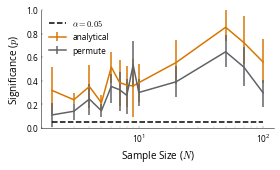

[0.3176769018173218, 0.23845635114997243, 0.35066748538043646, 0.21282632633240617, 0.5157667810703834, 0.38383321210109506, 0.36306872097487425, 0.3554884643776338, 0.3832441659138321, 0.554558173103305, 0.8530579154354602, 0.7229143606848858, 0.5584744657155589]


In [12]:
plt.figure(figsize=(4, 4/1.618))
yerr = np.stack((ls, us))
yerr[0, :] = np.array(ps) - yerr[0, :]
yerr[1, :] = yerr[1, :] - np.array(ps)
plt.errorbar(ns, ps, yerr=yerr, label='analytical')
yerr = np.stack((lps, ups))
yerr[0, :] = np.array(pps) - yerr[0, :]
yerr[1, :] = yerr[1, :] - np.array(pps)
plt.errorbar(ns, pps, yerr=yerr, label='permute')
plt.plot([np.min(ns), np.max(ns)], [0.05, 0.05], color='black', linestyle='--', label=r'$\alpha=0.05$')
plt.semilogx()
plt.legend()
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Significance ($p$)')
#plt.title('Under $H_{0}$')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.savefig('h0_analytical_significance.pdf')
plt.show()
print(ps)

# Alternative Hypothesis

In [13]:
ns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 70, 100]
ls = []
us = []
lps = []
ups = []
ps = []
u_ps = []
pps = []
u_pps = []
for n in tqdm.tqdm(ns):
    _ps = []
    _pps = []
    for j in range(10):
        pred = torch.normal(mean=1.0, std=1.0, size=(n, 3))
        true = torch.normal(mean=0.0, std=1.0, size=(n, 3))
        _ps.append(_ddks.p(pred, true))
        _pps.append(_ddks.permute(pred, true, J=100)[0])
    
    r = bs.bootstrap(np.array(_ps), stat_func=bs_stats.mean)
    ps.append(r.value)
    ls.append(r.lower_bound)
    us.append(r.upper_bound)
    r = bs.bootstrap(np.array(_pps), stat_func=bs_stats.mean)
    pps.append(r.value)
    lps.append(r.lower_bound)
    ups.append(r.upper_bound)

100%|██████████| 13/13 [05:33<00:00, 25.67s/it]


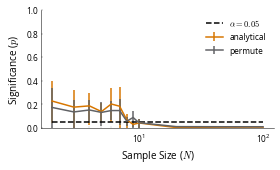

[0.2277805209159851, 0.17604187784426198, 0.18677133479070449, 0.13828820044253218, 0.20254662613329452, 0.18382189118948977, 0.06826704602135489, 0.029214137464202806, 0.04186929029152895, 0.0027990800091176604, 3.2122908605769496e-05, 1.3788500186073804e-07, 2.0871004924316593e-11]


In [14]:
plt.figure(figsize=(4, 4/1.618))
yerr = np.stack((ls, us))
yerr[0, :] = np.array(ps) - yerr[0, :]
yerr[1, :] = yerr[1, :] - np.array(ps)
plt.errorbar(ns, ps, yerr=yerr, label='analytical')
yerr = np.stack((lps, ups))
yerr[0, :] = np.array(pps) - yerr[0, :]
yerr[1, :] = yerr[1, :] - np.array(pps)
plt.errorbar(ns, pps, yerr=yerr, label='permute')
plt.plot([np.min(ns), np.max(ns)], [0.05, 0.05], color='black', linestyle='--', label=r'$\alpha=0.05$')
plt.semilogx()
plt.legend()
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Significance ($p$)')
#plt.title('Under $H_{a}$')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.savefig('ha_analytical_significance.pdf')
plt.show()
print(ps)

100%|██████████| 1000/1000 [23:21<00:00,  1.40s/it]


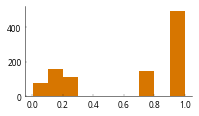

In [15]:
n = 50
_ps = []
for j in tqdm.tqdm(np.arange(1000)):
    pred = torch.normal(mean=0.0, std=1.0, size=(n, 3))
    true = torch.normal(mean=0.0, std=1.0, size=(n, 3))
    _ps.append(_ddks.p(pred, true))
plt.hist(_ps)
plt.show()

In [16]:
print(bs.bootstrap((np.array(_ps) <= 0.05), stat_func=bs_stats.mean))

0.042    (0.029000000000000005, 0.054000000000000006)


100%|██████████| 1000/1000 [52:48<00:00,  3.17s/it]


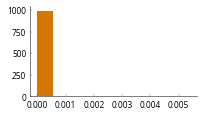

In [17]:
n = 50
_ps = []
for j in tqdm.tqdm(np.arange(1000)):
    pred = torch.normal(mean=1.0, std=1.0, size=(n, 3))
    true = torch.normal(mean=0.0, std=1.0, size=(n, 3))
    _ps.append(_ddks.p(pred, true))
plt.hist(_ps)
plt.show()

In [18]:
print(bs.bootstrap((np.array(_ps) >= 0.05), stat_func=bs_stats.mean))

0.0    (0.0, 0.0)
